**In this experiment, I aim to understand the impact of time trace length on the reliability of gene transcription data. The goal is to identify a threshold for time trace length, above which the data can be considered reliable.**

In [1]:
import os
os.chdir('./synthetic_gene')
%pwd

'C:\\Users\\user\\Desktop\\burstInfer1\\synthetic_gene'

### Generate Promoter State

In [2]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(6626285)

# Define transition probability matrix
transition_probabilities = np.array([
       [0.8549579 , 0.1450421 ],
       [0.20215972, 0.79784028]
])

number_of_traces = 200  # Number of Markov chains
length_of_each_trace = 360  # Length of each Markov chain

# Initialize matrix to store all Markov chains
chain_matrix = np.ones((number_of_traces, length_of_each_trace))

# Generate Markov chains
for j in range(number_of_traces):
    starting_value = 0  # Initial state (indexing starts from 0 in Python)
    chain_length = length_of_each_trace
    chain = np.zeros(chain_length)
    chain[0] = starting_value
    for i in range(1, chain_length):
        this_step_distribution = transition_probabilities[int(chain[i - 1])]
        cumulative_distribution = np.cumsum(this_step_distribution)
        r = np.random.rand()
        chain[i] = np.where(cumulative_distribution > r)[0][0]
    chain_matrix[j, :] = chain

# Save the results to a CSV file
output_path = 'long_gene_w5.csv'
pd.DataFrame(chain_matrix).to_csv(output_path, header=False, index=False)

print(f"Data saved to {output_path}")


Data saved to long_gene_w5.csv


### Generate Traces 

In [3]:
# Revise create_synthetic_fluorescent_traces_w5.py to modify noise level
##### Generate traces (Without adding noise)

import sys
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(os.path.abspath("../burstInfer"))
from get_adjusted import get_adjusted  
from ms2_loading_coeff import ms2_loading_coeff 

def generate_fluorescent_traces(noise_level, input_file, output_file):
    # Set random seed
    seed_setter = 633463
    np.random.seed(seed_setter)
    np.seterr(divide='ignore')

    # Import data
    signal_holder = genfromtxt(input_file, delimiter=',')

    # Initialize parameters
    K = 2
    n_traces = len(signal_holder)
    W = 5
    mu = np.array([[150], [8000]])
    noise = noise_level

    t_MS2 = 30
    deltaT = 20
    kappa = t_MS2 / deltaT

    # Compute MS2 coefficients
    ms2_coeff = ms2_loading_coeff(kappa, W)
    ms2_coeff_flipped = np.flip(ms2_coeff, 1)
    count_reduction_manual = np.zeros((1, W-1))
    for t in range(W-1):
        count_reduction_manual[0, t] = np.sum(ms2_coeff[0, t+1:])
    count_reduction_manual = np.reshape(count_reduction_manual, (W-1, 1))

    mask = np.int32((2**W)-1)

    # Determine the length of the traces from the first row of signal_holder
    length = len(signal_holder[0])
    fluorescence_holder = np.zeros((n_traces, length))

    for i in range(n_traces):
        single_promoter = signal_holder[i, :]
        single_trace = np.zeros(length)
        
        window_storage = int(single_promoter[0])
        single_trace[0] = ((get_adjusted(window_storage, K, W, ms2_coeff)[0] * mu[1, 0]) + 
                           (get_adjusted(window_storage, K, W, ms2_coeff)[1] * mu[0, 0])) + np.random.normal(0, noise)
        
        present_state_list = [int(single_promoter[0])]
        
        for t in range(1, length):
            present_state = int(single_promoter[t])
            window_storage = np.bitwise_and((present_state_list[t-1] << 1) + present_state, mask)
            present_state_list.append(window_storage)
            single_trace[t] = ((get_adjusted(window_storage, K, W, ms2_coeff)[0] * mu[1, 0]) + 
                               (get_adjusted(window_storage, K, W, ms2_coeff)[1] * mu[0, 0])) + np.random.normal(0, noise)
            
        fluorescence_holder[i, :] = single_trace

    # Encapsulate data into a DataFrame and return
    sampling_dataframe = pd.DataFrame(fluorescence_holder)
    sampling_dataframe.to_csv(output_file, index=False)
    return sampling_dataframe

# Parameters
noise_level = 0
input_file = 'long_gene_w5.csv'
output_file = 'long_gene_w5_fluorescent_traces.csv'

# Generate traces
traces = generate_fluorescent_traces(noise_level, input_file, output_file)
print("Generate fluorescent traces finish!")


15:09:12.271147
start program
Generate fluorescent traces finish!


In [4]:
traces

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,637.5,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,3254.166667,10450.000000,18300.0,...,16337.500000,8487.500000,637.500000,637.500000,637.5,637.500000,637.500000,637.500000,637.500000,637.500000
1,637.5,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.5,...,3254.166667,10450.000000,18300.000000,26150.000000,34000.0,34000.000000,34000.000000,34000.000000,31383.333333,24187.500000
2,637.5,637.500000,637.500000,637.500000,3254.166667,10450.000000,15683.333333,16337.500000,18954.166667,18300.0,...,24187.500000,16337.500000,11104.166667,10450.000000,18300.0,26150.000000,34000.000000,31383.333333,24187.500000,16337.500000
3,637.5,637.500000,637.500000,637.500000,637.500000,3254.166667,10450.000000,18300.000000,23533.333333,24187.5,...,18300.000000,26150.000000,34000.000000,34000.000000,34000.0,34000.000000,34000.000000,34000.000000,31383.333333,24187.500000
4,637.5,637.500000,3254.166667,10450.000000,18300.000000,23533.333333,24187.500000,16337.500000,8487.500000,637.5,...,3254.166667,10450.000000,18300.000000,26150.000000,34000.0,34000.000000,34000.000000,34000.000000,34000.000000,31383.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,637.5,3254.166667,10450.000000,18300.000000,26150.000000,34000.000000,34000.000000,34000.000000,34000.000000,34000.0,...,26150.000000,31383.333333,24187.500000,18954.166667,18300.0,15683.333333,16337.500000,16337.500000,8487.500000,637.500000
196,637.5,637.500000,637.500000,637.500000,3254.166667,10450.000000,18300.000000,26150.000000,34000.000000,34000.0,...,10450.000000,15683.333333,16337.500000,16337.500000,8487.5,637.500000,637.500000,637.500000,637.500000,637.500000
197,637.5,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.500000,637.5,...,8487.500000,637.500000,637.500000,637.500000,637.5,637.500000,3254.166667,10450.000000,18300.000000,26150.000000
198,637.5,637.500000,637.500000,3254.166667,7833.333333,8487.500000,8487.500000,8487.500000,637.500000,637.5,...,637.500000,637.500000,637.500000,637.500000,637.5,637.500000,3254.166667,10450.000000,18300.000000,23533.333333


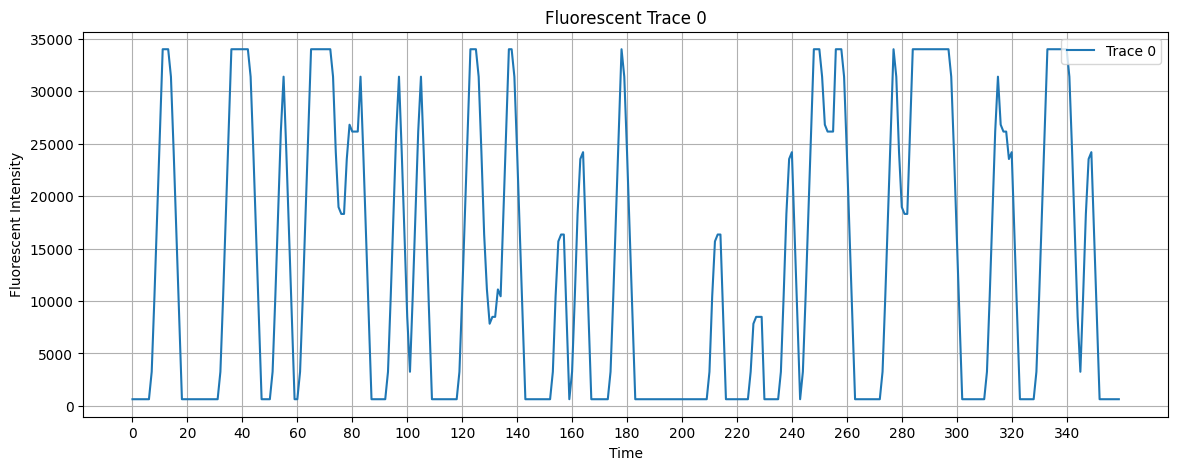

In [5]:
##### Plot the first trace

import pandas as pd
import matplotlib.pyplot as plt

def plot_traces_separately(input_file, num_traces=10):
    """
    Plot each trace in separate figures from the input CSV file.
    
    Parameters:
    input_file (str): Path to the input CSV file with fluorescent traces.
    num_traces (int): Number of traces to plot (default is 10).
    """
    # Load the fluorescent traces
    traces_df = pd.read_csv(input_file)
    
    # Plot each trace in separate figures
    for i in range(num_traces):
        plt.figure(figsize=(14,5))
        plt.plot(traces_df.iloc[i], label=f'Trace {i}')
        plt.title(f'Fluorescent Trace {i}')
        plt.xlabel('Time')
        plt.ylabel('Fluorescent Intensity')
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.xticks(ticks=range(0, len(traces_df.columns), 20))
        plt.show()

input_file = 'long_gene_w5_fluorescent_traces.csv'
plot_traces_separately(input_file, num_traces=1)


### Compute Autocorrelation for Noise Free Traces from 60 to 360 (Interval = 20)

In [6]:
import numpy as np
import pandas as pd

def compute_autocorrelation(signal, max_lag):
    """
    Compute autocorrelation for a given signal.
    
    Parameters:
    signal (numpy array): Input signal.
    max_lag (int): Maximum lag value for autocorrelation.
    
    Returns:
    list: Autocorrelation values for the given signal.
    """
    n = len(signal)
    mean_signal = np.mean(signal)
    var_signal = np.var(signal)
    
    autocorr = [1.0]  # lag 0 autocorrelation is always 1
    
    for lag in range(1, max_lag + 1):
        if lag < n:
            cov = np.sum((signal[:n - lag] - mean_signal) * (signal[lag:] - mean_signal)) / n
            autocorr.append(cov / var_signal)
        else:
            autocorr.append(np.nan)  # Not enough data to compute autocorrelation for this lag, replace NaN with 0
    
    return autocorr

def compute_autocorrelation_for_traces(traces, lengths):
    """
    Compute autocorrelation for each trace at different lengths.
    
    Parameters:
    traces (DataFrame): Input data containing traces.
    lengths (list): List of lengths to test.
    
    Returns:
    DataFrame: DataFrame containing autocorrelation values for each trace at different lengths.
    """
    results = []

    # Iterate over each trace
    for trace_index, row in traces.iterrows():
        signal = row.values.flatten()  # Get the signal data
        
        for length in lengths:
            truncated_signal = signal[:length]  # Truncate signal to the current length
            autocorr = compute_autocorrelation(truncated_signal, length)
            results.append([trace_index, length] + autocorr)
    
    # Create DataFrame with the results
    columns = ['Trace', 'Length'] + [f'Lag_{lag}' for lag in range(max(lengths) + 1)]
    autocorr_df = pd.DataFrame(results, columns=columns)
    
    return autocorr_df

# Load the input data
input_file = 'long_gene_w5_fluorescent_traces.csv'
traces = pd.read_csv(input_file)

# Define the different lengths you want to test (from 50 to 300)
lengths = list(range(60, 361, 20))

# Compute autocorrelation for each length
autocorr_df = compute_autocorrelation_for_traces(traces, lengths)

# Save the results to a new CSV file
output_file = 'extended_autocorrelation_results.csv'
autocorr_df.to_csv(output_file, index=False)
print("Autocorrelation computation finished and saved to CSV!")


Autocorrelation computation finished and saved to CSV!


In [7]:
autocorr_df

,Trace,Length,Lag_0,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,...,Lag_351,Lag_352,Lag_353,Lag_354,Lag_355,Lag_356,Lag_357,Lag_358,Lag_359,Lag_360
0,0,60,1.0,0.920216,0.745916,0.516183,0.272803,0.057810,-0.124677,-0.271908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,80,1.0,0.928628,0.766900,0.553868,0.326470,0.124666,-0.037599,-0.157939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,100,1.0,0.926425,0.754735,0.530611,0.297238,0.093042,-0.070444,-0.188208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,120,1.0,0.921766,0.740354,0.508438,0.279457,0.099917,-0.027143,-0.109464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,140,1.0,0.915432,0.721108,0.470834,0.225324,0.030918,-0.104740,-0.190663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,199,280,1.0,0.942454,0.815386,0.654855,0.489793,0.352676,0.243888,0.150811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3196,199,300,1.0,0.940257,0.806345,0.636446,0.462349,0.318150,0.204376,0.107492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3197,199,320,1.0,0.934953,0.791874,0.612074,0.430097,0.282064,0.166679,0.070891,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3198,199,340,1.0,0.934468,0.791860,0.614537,0.435407,0.287807,0.170054,0.069424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Autocorrelation Function and Dwell time at Different Time Trace Lengths.

Figure 7. Autocorrelation Function at Different Time Trace Lengths.


D:\anaconda\envs\envs_notebook\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


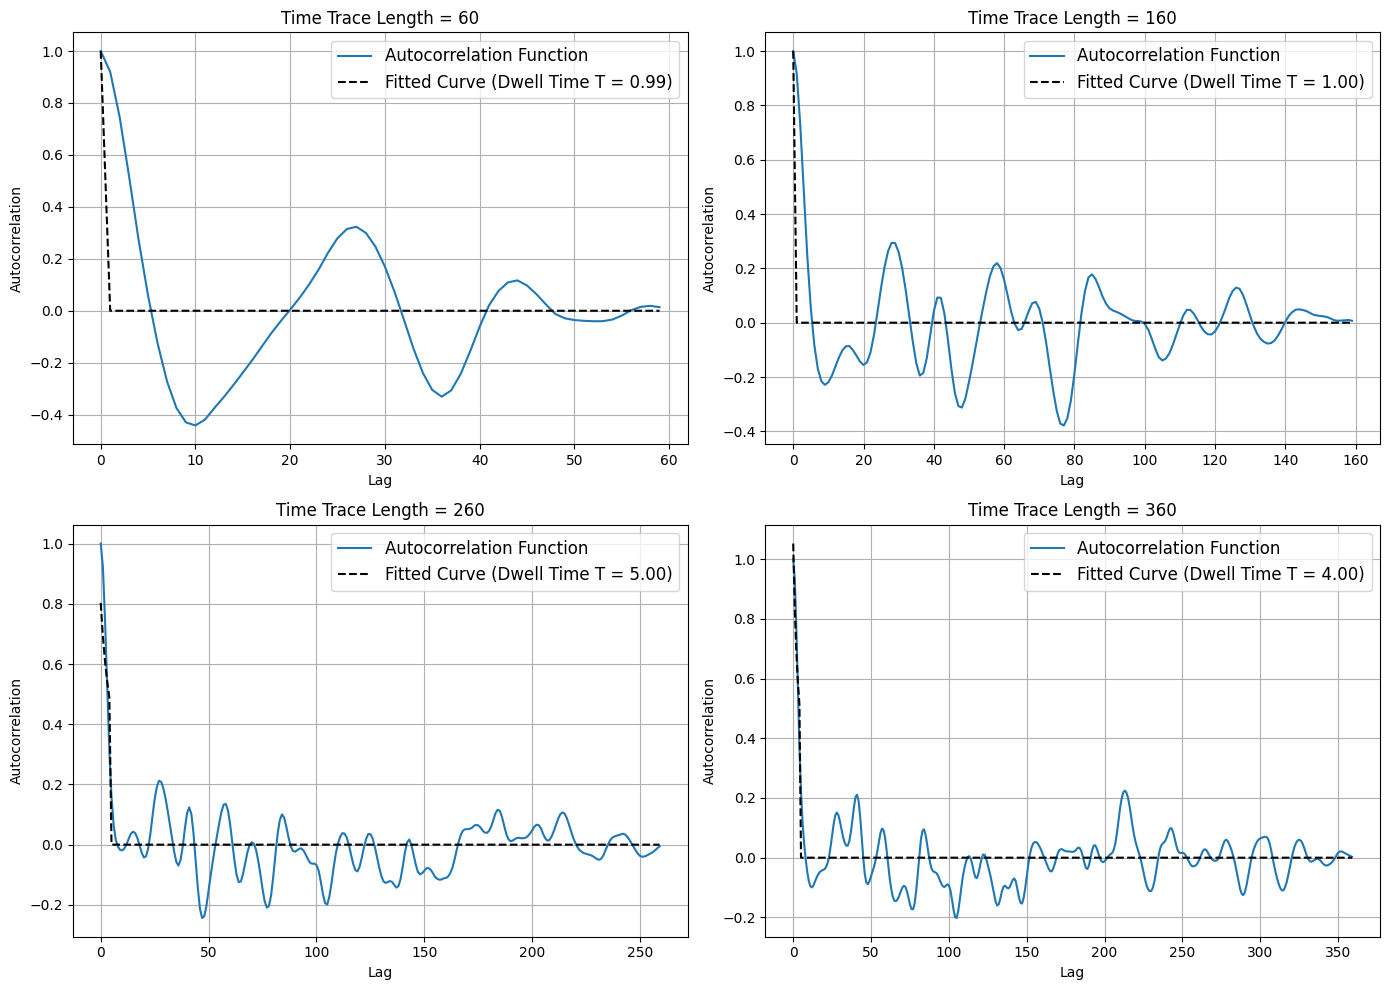

In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def heaviside(x):
    return np.where(x >= 0, 1.0, 0.0)

def autocorrelation_function_method1(tau, c, T):
    return (c * T / (1 + c * tau)) * heaviside(T - tau)

def calculate_dwell_time_method1(tau_values, G_values):
    # Initial guesses for c and T
    initial_guess = [1.0, 100.0]  # These values may need adjustment based on your data

    # Fit the curve
    params, _ = curve_fit(autocorrelation_function_method1, tau_values, G_values, p0=initial_guess)
    
    # Extract fitted parameters
    c, T = params
    
    return c, T

def plot_autocorrelation_with_dwell_time(ax, tau_values, G_values, c, T, length):
    # Original autocorrelation function data
    ax.plot(tau_values, G_values, label='Autocorrelation Function')
    
    # Calculate the fitted curve
    G_fit_values = autocorrelation_function_method1(tau_values, c, T)
    
    # Plot the fitted curve
    ax.plot(tau_values, G_fit_values, label=f'Fitted Curve (Dwell Time T = {T:.2f})', linestyle='--', color='black')
    
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_title(f'Time Trace Length = {length}')
    ax.legend(fontsize=12)
    ax.grid(True)

print("Figure 7. Autocorrelation Function at Different Time Trace Lengths.")
# Load the autocorrelation results from CSV file
input_autocorr_file = 'extended_autocorrelation_results.csv'
autocorr_df = pd.read_csv(input_autocorr_file)

# Create subplots for Length = 60, 160, 260, and 360
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns

length_values = [60, 160, 260, 360]

for i, length in enumerate(length_values):
    # Select the data for the given Length value
    row = autocorr_df[(autocorr_df["Trace"] == 0) & (autocorr_df["Length"] == length)]
    
    G_values = row.iloc[0, 2:length+2].values
    tau_values = np.arange(len(G_values))

    # Calculate dwell time using method 1
    c, T = calculate_dwell_time_method1(tau_values, G_values)

    # Plot autocorrelation function with dwell time and the fitted curve on the respective subplot
    plot_autocorrelation_with_dwell_time(axs[i // 2, i % 2], tau_values, G_values, c, T, length)

# Adjust layout
plt.tight_layout()
plt.show()


Figure 7 clearly illustrates that the time trace length significantly impacts the calculation of dwell time. Sufficient time trace length is essential for accurately capturing the dynamic changes in gene expression. 

- **At low time trace lengths (e.g., 60 or 160):** The autocorrelation function shows noticeable fluctuations, and the fitted dwell time is quite short (around 1 second). This suggests that shorter time traces fail to fully capture the underlying dynamics, leading to less reliable estimates of dwell time.

- **At higher time trace lengths (e.g., 260 or 360):** The autocorrelation function stabilizes, and the fitted dwell time converges to a more consistent value (around 4 to 5 seconds). This indicates that longer time traces provide a more accurate and reliable representation of the gene expression dynamics, reducing the variability in the dwell time estimation.

### Dwell Time Distribution Across Different Time Trace Lengths


D:\anaconda\envs\envs_notebook\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Figure 10: Dwell Time Distribution Across Different Time Trace Lengths


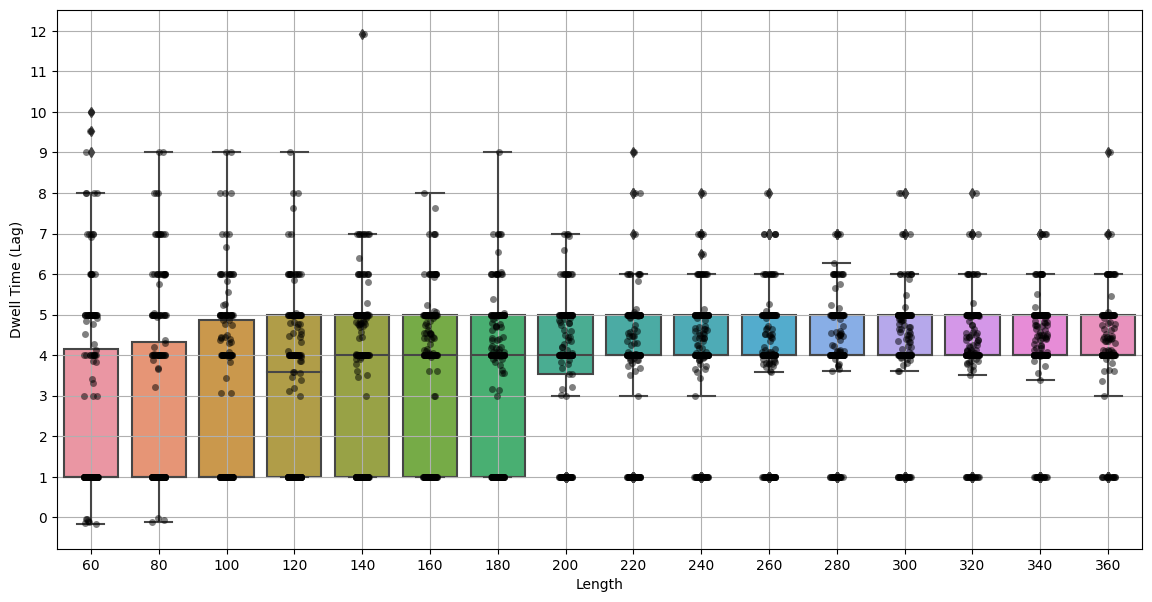

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.optimize import curve_fit

# Load the autocorrelation results from CSV file
input_autocorr_file = 'extended_autocorrelation_results.csv'
autocorr_df = pd.read_csv(input_autocorr_file)

# Initialize results list
results = []

def heaviside(x):
    return np.where(x >= 0, 1.0, 0.0)

def autocorrelation_function_method1(tau, c, T):
    return (c * T / (1 + c * tau)) * heaviside(T - tau)

def calculate_dwell_time_method1(tau_values, G_values):
    if np.isnan(G_values).any():
        return 0, 0  # Return 0 for both c and T if G_values contain NaNs
    
    # Initial guesses for c and T
    initial_guess = [1.0, 100.0]

    # Fit the curve
    params, _ = curve_fit(autocorrelation_function_method1, tau_values, G_values, p0=initial_guess)
    
    # Extract fitted parameters
    c, T = params
    
    return c, T

for trace in range(200):
    trace_data = autocorr_df[autocorr_df["Trace"] == trace]
    for length in trace_data["Length"].unique():
        length_data = trace_data[trace_data["Length"] == length]
        if not length_data.empty:
            G_values = length_data.iloc[0, 2:length+2].values
            tau_values = np.arange(len(G_values))
            c, T = calculate_dwell_time_method1(tau_values, G_values)
            results.append({"Trace": trace, "Length": length, "Dwell Time (T)": T})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Box plot of dwell time vs. Length
print("Figure 10: Dwell Time Distribution Across Different Time Trace Lengths")
plt.figure(figsize=(14, 7))
sns.boxplot(x='Length', y='Dwell Time (T)', data=results_df)
sns.stripplot(x='Length', y='Dwell Time (T)', data=results_df, color='black', alpha=0.5, jitter=True)
plt.xlabel('Length')
plt.ylabel('Dwell Time (Lag)')
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.grid(True)
plt.show()

Figure 10 illustrates the distribution of dwell times across different time trace lengths. Each box represents the interquartile range (IQR) of dwell times for a specific time trace length, with the line inside the box indicating the median dwell time. The whiskers extend to show the range of the data, and outliers are displayed as individual points.

- **Shorter Time Trace Lengths (e.g., 60 to 160):** The dwell time distribution is wide and shows significant variability, with many outliers. This indicates that shorter time traces do not consistently capture the dynamics of the system, leading to less reliable estimates of dwell time.

- **Longer Time Trace Lengths (e.g., 260 to 360):** The dwell time distribution becomes narrower and more consistent, with the median dwell time stabilizing around 4 to 5 lag units. This suggests that as the time trace length increases, the estimates of dwell time become more reliable, with reduced variability and fewer outliers.

### Determining the Stable Point

In contrast to the SNR experiment, where we have the Ground Truth to know what is correct, in this time trace length experiment, we can only rely on observing convergence. Therefore, we developed an alternative method. We calculate the relative change between consecutive time trace lengths, and if this value is less than 2%, we consider the curve to have converged.

Figure 11. Stabilization of Mean Dwell Time at Increasing Time Trace Lengths


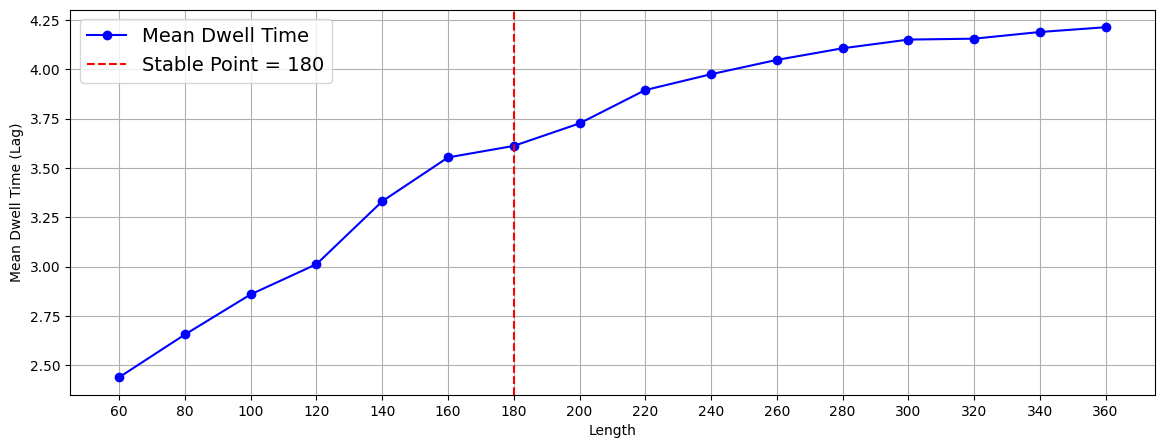

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Load the results DataFrame from the first part if not already loaded
results_df = pd.DataFrame(results)

# Calculate the mean dwell time for each length
mean_dwell_time = results_df.groupby('Length')['Dwell Time (T)'].mean().reset_index()

# Calculate the relative change in mean dwell time
relative_change = mean_dwell_time['Dwell Time (T)'].pct_change().abs()

# Define the threshold for relative change (e.g., 5%)
threshold = 0.02

# Find the first length where the relative change is below the threshold
stable_length_index = relative_change[relative_change < threshold].index[0]
stable_length = mean_dwell_time['Length'].iloc[stable_length_index]

# Mean dwell time vs. Length with stable point
print("Figure 11. Stabilization of Mean Dwell Time at Increasing Time Trace Lengths")
plt.figure(figsize=(14, 5))
plt.plot(mean_dwell_time['Length'], mean_dwell_time['Dwell Time (T)'], marker='o', color='blue', label='Mean Dwell Time')
plt.axvline(x=stable_length, color='red', linestyle='--', label=f'Stable Point = {stable_length}')
plt.xlabel('Length')
plt.ylabel('Mean Dwell Time (Lag)')
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.grid(True)
plt.legend(fontsize=14)
plt.show()


Figure 11 shows that the mean dwell time stabilizes at around 180 time units, indicating that the data has reached a stable state.